# Dataset BioASQ: QAPair

### 0. Initial setup (0)

In [471]:
import json
import sys
sys.path.insert(0,'common/')
import nlp_util
from bs4 import BeautifulSoup
import requests
import sys,os,os.path
import re
import spacy
import random
import seaborn as sns
import tqdm
import pprint
from scipy import stats
import numpy as np
import seaborn as sns
from fuzzywuzzy import fuzz
np.set_printoptions(precision=4)

In [473]:
biosent_path = '/data2/bioasq/embeddings/biosent_vect/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
GOLD_PATH = 'gold_standard/'
files = [(f"{GOLD_PATH}BioASQ-trainingDataset{i}b.json", i) for i in [4, 5, 6, 7, 8]]
files

[('gold_standard/BioASQ-trainingDataset4b.json', 4),
 ('gold_standard/BioASQ-trainingDataset5b.json', 5),
 ('gold_standard/BioASQ-trainingDataset6b.json', 6),
 ('gold_standard/BioASQ-trainingDataset7b.json', 7),
 ('gold_standard/BioASQ-trainingDataset8b.json', 8)]

### Dataset Preprocess Stats

In [278]:
fuzzy_sim_threshold = 80
question_count = 0
question_pairs_count = 0
qa_count_list = []
for (file, trainset) in files:
    bioasq = json.load(open(file, "r"))
    for question in bioasq['questions']:
        question_count += 1
        len_a = 0
        if 'snippets' in question:
            len_a = len([answer for answer in question['snippets']])
            question_pairs_count += len_a
        qa_count_list.append(len_a)

In [279]:
print('# questions {}, # pairs {}'.format(question_count,question_pairs_count))
print('# Stats answers per question: ')
print(stats.describe(qa_count_list))
print('# question without answer {}'.format(len(qa_count_list)-np.count_nonzero(qa_count_list)) )

# questions 11347, # pairs 173253
# Stats answers per question: 
DescribeResult(nobs=11347, minmax=(0, 126), mean=15.26861725566229, variance=193.7709549272643, skewness=2.3711926050954735, kurtosis=9.238227180052318)
# question without answer 21


### Preprocess Dataset 

In [280]:
nlp = spacy.load("en_core_web_sm")

In [281]:
pp = pprint.PrettyPrinter(indent=4)

In [476]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance

model = sent2vec.Sent2vecModel()
try:
    model.load_model(biosent_path)
    print('biosentvec model successfully loaded')
except Exception as e:
    print(e)

model successfully loaded


In [477]:
stop_words = set(stopwords.words('english'))
def biosent_preprocess(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

In [486]:
def biosent_similarity(sent1, sent2):
    sentence_1 = biosent_preprocess(sent1)
    sentence_vector_1 = model.embed_sentence(sentence_1)
    sentence_2 = biosent_preprocess(sent2)
    sentence_vector_2 = model.embed_sentence(sentence_2)
    cosine_sim = 1 - distance.cosine(sentence_vector_1, sentence_vector_2)
    return cosine_sim

In [489]:
biosent_similarity('test','test')

1.0

In [284]:
def get_answer_id(answer):
    return answer['document'].split('/')[-1]

def get_pair_id(question, answer):
    params = [
        question['id'], # question id
        get_answer_id(answer),
        answer['beginSection'],
        str(answer['offsetInBeginSection']),
        answer['endSection'],
        str(answer['offsetInEndSection'])
    ]

    return '-'.join(params)

In [285]:
def build_pair(question, passage, trainset, is_answer, doc_related, bioSentVecCosSim):
    '''Build a single QAPair object given its stats (is_answer, doc_related, bioSentVecCosSim).'''
    
    pair = {}
    pair['pairId'] = get_pair_id(question, passage)
    pair['questionId'] = question['id']
    pair['question'] = question['body']
    pair['passage'] = passage['text']
    pair['trainset'] = f"{trainset}b"
    pair['doc_url'] = passage['document']
    pair['is_answer'] = is_answer
    pair['doc_related'] = doc_related
    pair['bioSentVecCosSim'] = bioSentVecCosSim
    pair['beginSection'] = passage['beginSection']
    pair['offsetInBeginSection'] = passage['offsetInBeginSection']
    pair['endSection'] = passage['endSection']
    pair['offsetInEndSection'] = passage['offsetInEndSection']
    return pair

In [430]:
import itertools
from operator import itemgetter

#with 2 deviations we endup with 95% of the data
def mad_stats_filter(data, deviations=2):
    data = np.array(data)
    d = np.abs(data - np.median(data))
    med_abs_dev = np.median(d)
    s = d / med_abs_dev
    filtered = data[s < deviations]
    return filtered

def qa_pair_stats(pairs):
    data_stats = {}
    len_seq_q = []
    num_terms_q = []
    len_seq_a = []
    num_terms_a = []
    
    sorted_pairs = sorted(pairs, key=itemgetter('questionId'))
    for key, value in itertools.groupby(sorted_pairs, key=itemgetter('questionId')):
        for i, a in enumerate(value):
            if a['beginSection'] == 'abstract':
                if i == 0:
                    len_seq_q.append(len(a['question']))
                    num_terms_q.append(len(nlp_util.tokenize(a['question'])))
                len_seq_a.append(len(a['passage']))
                num_terms_a.append(len(nlp_util.tokenize(a['passage'])))
    
    data_stats['seq_a'] = len_seq_a
    data_stats['seq_q'] = len_seq_q
    data_stats['terms_a'] = num_terms_a
    data_stats['terms_q'] = num_terms_q
    data_stats['len_seq_q_stats'] = stats.describe(len_seq_q)
    data_stats['terms_q_stats'] = stats.describe(num_terms_q)
    data_stats['len_seq_a_stats'] = stats.describe(len_seq_a)
    data_stats['terms_a_stats'] = stats.describe(num_terms_a)
    #mad filtering (Median absolute deviation)
    data_stats['mad_terms_q_stats'] = stats.describe(mad_stats_filter(num_terms_q))
    data_stats['mad_terms_a_stats'] = stats.describe(mad_stats_filter(num_terms_a))
    
    return data_stats

data_stats = qa_pair_stats(positive_pairs)

In [431]:
data_stats['len_seq_q_stats']

DescribeResult(nobs=2064, minmax=(13, 215), mean=58.32897286821706, variance=546.5824660312558, skewness=0.9218530924755453, kurtosis=1.9204553219796932)

Text(0.5, 1.0, 'question sequence lenght')

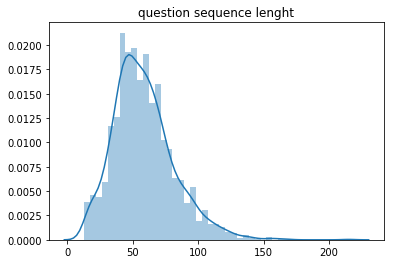

In [432]:
sns.distplot(data_stats['seq_q']).set_title('question sequence lenght')

In [433]:
data_stats['len_seq_a_stats']

DescribeResult(nobs=28452, minmax=(4, 2467), mean=276.3698861239983, variance=35446.741461404905, skewness=3.3545879786157573, kurtosis=18.497114868482537)

Text(0.5, 1.0, 'answer passage sequence lenght')

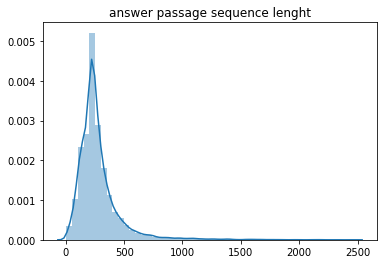

In [434]:
sns.distplot(data_stats['seq_a']).set_title('answer passage sequence lenght')

In [435]:
data_stats['terms_q_stats']

DescribeResult(nobs=2064, minmax=(2, 31), mean=8.944767441860465, variance=12.018276048653462, skewness=0.9292484385888287, kurtosis=1.9826278516699691)

In [436]:
data_stats['mad_terms_q_stats']

DescribeResult(nobs=1494, minmax=(6, 12), mean=8.700133868808567, variance=3.2924715158916538, skewness=0.20393552589809935, kurtosis=-0.9651740964201565)

Text(0.5, 1.0, 'question number of terms')

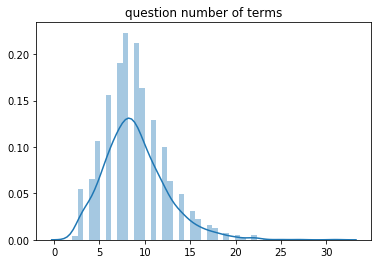

In [437]:
sns.distplot(data_stats['terms_q']).set_title('question number of terms')

In [438]:
data_stats['terms_a_stats']

DescribeResult(nobs=28452, minmax=(1, 401), mean=41.20715591171095, variance=835.659169205173, skewness=3.4883836945044067, kurtosis=20.443476597868415)

In [439]:
data_stats['mad_terms_a_stats']

DescribeResult(nobs=22257, minmax=(14, 56), mean=33.27820460978568, variance=104.70243336880873, skewness=0.1518787419807237, kurtosis=-0.6608115144183802)

Text(0.5, 1.0, 'answer passage number of terms')

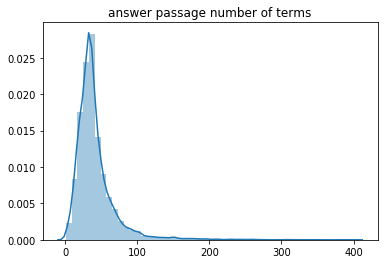

In [440]:
sns.distplot(data_stats['terms_a']).set_title('answer passage number of terms')

### 1. Positive Pairs 

In [299]:
import copy
pos_question_pass_dict = {}

def repeated_passage(qp_dict, passage, question_id):
    if question_id not in qp_dict:
        qp_dict[question_id] = [passage.lower()]
        return False
    for p in qp_dict[question_id]:
        score = fuzz.ratio(p.lower(),passage)
        if score > fuzzy_sim_threshold:
            #print('Found a repeated passage score: {}'.format(score))
            #print('passage repeated: \n\n{} \n\n{}\n'.format(p.lower(),passage.lower()))
            return True
    qp_dict[question_id].append(passage.lower())
    return False
            
repeated_passages = 0
def get_qa_positive_pairs(question, trainset):
    '''Transform a BioASQ question into a QAPair gold object.'''    
    pairs = []
    global repeated_passages
    try:
        if 'snippets' in question:
            for idx_pass, passage in enumerate(question['snippets']):
                if repeated_passage(pos_question_pass_dict, passage['text'], question['id']) is False:
                    pairs.append(build_pair(question, passage, trainset, 
                                            is_answer=1, doc_related=1, bioSentVecCosSim=1))
                else:
                    repeated_passages += 1
                    #print('qid: {}, trainset: {}, idx_passage: {}\n\n\n\n'.format(question['id'],trainset,idx_pass))
    except Exception as e:
        print('Error processing question in trainset {} question:'.format(trainset))
        pp.pprint(question)
        print(e)
        return
    return pairs

In [303]:
positive_pairs = []
import tqdm
for (file, trainset) in tqdm.tqdm(files, position=0):
    bioasq = json.load(open(file, "r"))
    for question in tqdm.tqdm(bioasq['questions'], position=0):
        positive_pairs.extend(get_qa_positive_pairs(question, trainset))

pp.pprint(positive_pairs[0])

100%|██████████| 5/5 [24:07<00:00, 289.51s/it]

{   'beginSection': 'abstract',
    'bioSentVecCosSim': 1,
    'doc_related': 1,
    'doc_url': 'http://www.ncbi.nlm.nih.gov/pubmed/11772304',
    'endSection': 'abstract',
    'is_answer': 1,
    'offsetInBeginSection': 475,
    'offsetInEndSection': 760,
    'pairId': '52bf209303868f1b0600001a-11772304-abstract-475-abstract-760',
    'passage': 'Alteplase is most effective when given early in MI and is '
               'probably ineffective when given 12 h after the onset of '
               'symptoms. The effectiveness of alteplase in MI can be '
               'increased by front loading with a bolus of 15 mg, followed by '
               'an infusion of 50 mg over 30 min and 35 mg over 60 min.',
    'question': 'What are the indications for alteplase?',
    'questionId': '52bf209303868f1b0600001a',
    'trainset': '4b'}


In [305]:
print('Number of positive pairs: {}, repeated passages {}'.format(len(positive_pairs),repeated_passages) )

Number of positive pairs: 32944, repeated passages 157197


In [306]:
import json
with open('generated_pairs/positive_pairs.json', 'w') as pos:
    json.dump(positive_pairs, pos)

In [559]:
#load
positive_pairs = json.load(open('generated_pairs/positive_pairs.json', 'r'))

#### Find Hard Negative threshold


In [ ]:
def positive_biosent_scores(pairs):
    sim_scores = []
    for p in tqdm.tqdm(pairs, position=0):
        score = biosent_similarity(p['passage'],p['question'])
        if np.isnan(score):
            print('pair biosentvec cos similarity is nan \n{}, \n\n{}\n'.format(p['question'],p['passage']))
        else:
            sim_scores.append(score)
    return sim_scores

In [ ]:
biosent_postives_scores = positive_biosent_scores(positive_pairs)

/home/aerossom/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'positive pairs cosine similarity')

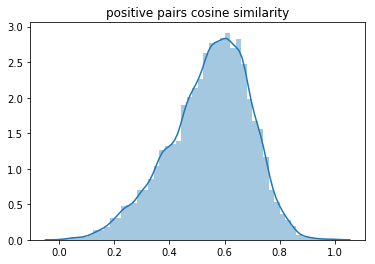

In [562]:
sns.distplot(biosent_postives_scores).set_title('positive pairs cosine similarity')

### 2. Negative Hard Questions

In [593]:
import ranking
import datetime
import time
from elasticsearch import Elasticsearch
import bioasq_util
import importlib
importlib.reload(bioasq_util)

ts = datetime.datetime.fromtimestamp(int(time.time())).strftime('%d-%m-%Y_%H-%M')
os_params = {
    'es_host': os.environ.get('es_host', '168.176.36.10:9200'),
    'es_index': os.environ.get('es_index', '2018_pubmed_baseline_title_abs_mesh'),
}
bioasq_util.es = Elasticsearch(hosts=[os_params['es_host']])
index_name = os_params['es_index']
doc_relative_url = 'http://www.ncbi.nlm.nih.gov/pubmed/'

def remove_similar_chunks(passages, gold_passages, fuzzy_sim_th=40):
    new_passages = []
    for p in passages:
        repeated = False
        for gp in gold_passages:
            ratio = fuzz.partial_ratio(p['text'], gp)
            if ratio > fuzzy_sim_th:
                repeated = True
                #print('\n\nremoved {} \n\n ------ is similar ({}) to: {}\n'.format(p['text'],ratio,gp))
                break
        if repeated == False:
            new_passages.append(p)
    return new_passages

#the parameters to exclude passages must be based on positive stats, we use
#the robust measure of variability MAD to filterout passages minmax=(13, 55)
def extract_neg_doc_passages(doc, gold_passages, minmax_terms=(13, 55)):
    doc_id = doc.replace(doc_relative_url,'')
    doc_tuple = bioasq_util.get_doc(doc_id, index_name, remove_tags=True)
    if doc_tuple is None:
        return [],[]
    doc_id, doc_title, doc_abstract = doc_tuple
    #remove gold passages
    for gp in gold_passages:
        doc_abstract = doc_abstract.replace(gp, '')
        doc_title = doc_title.replace(gp, '')
    chunks_title = ranking.split_chunks(doc_title)
    chunks_abstract = ranking.split_chunks(doc_abstract)
    #remove fuzzy similar togold passages in abstract
    chunks_abstract = remove_similar_chunks(chunks_abstract, gold_passages)
    #remove passages out of positive stat behaviour
    chunks_abstract = [ x for x in chunks_abstract
                           if (minmax_terms[1] > len(nlp_util.tokenize(x['text'])) > minmax_terms[0]) ]
    return chunks_title, chunks_abstract

In [594]:
gold_passages = ['Iron deficiency is common in pregnancy, postpartum, inflammatory bowel disease, chronic kidney disease, chronic heart failure, heavy uterine bleeding, cancer and following surgery. We estimate the budget impact (BI) on the Swiss mandatory health insurance associated with substituting iron sucrose (standard) with ferric carboxymaltose (new treatment) using real-life data.']
title, abst = extract_neg_doc_passages('http://www.ncbi.nlm.nih.gov/pubmed/20301588',gold_passages)
#filter passages that are not similar to question
#chunks_abstract =  [ x for x in chunks_abstract
#                           if (biosent_similarity('test','test') len(nlp_util.tokenize(x['text'])) > minmax_terms[0]) ]
#print(abst)

In [595]:
import traceback

In [602]:
def get_hard_negative_pairs(question, trainset, biosent_sim_th=0.3):
    pairs = []
    gold_passages = []
    try:
        #get gold passages
        if 'snippets' in question:
            for idx_pass, passage in enumerate(question['snippets']):
                gold_passages.append(passage['text'])
        #extract passages from related documents
        if 'documents' in question:
            for idx_doc, doc in enumerate(question['documents']):
                #extract title and abstract passage keeping similar positive stats
                title, abst = extract_neg_doc_passages(doc,gold_passages)
                # validate if the pair is close to the question based on positive biosentvec threshold
                for p in abst:
                    score = biosent_similarity(p['text'],question['body'])
                    if score > biosent_sim_th:
                        p['document'] = doc
                        p['endSection'] = p['beginSection'] = 'abstract'
                        pairs.append(build_pair(question, p, trainset, 
                                            is_answer=0, doc_related=1, bioSentVecCosSim=score))
                for p in title:
                    score = biosent_similarity(p['text'],question['body'])
                    if score > biosent_sim_th:
                        p['document'] = doc
                        p['endSection'] = p['beginSection'] = 'title'
                        pairs.append(build_pair(question, p, trainset, 
                                            is_answer=0, doc_related=1, bioSentVecCosSim=score))
    except Exception as e:
        print('Error processing question in trainset {} question:'.format(trainset))
        pp.pprint(question)
        traceback.print_exc()
        return
    return pairs

In [607]:
"""gold_passages_t1 = ['Muenke syndrome is an autosomal dominant disorder characterized by coronal suture craniosynostosis, hearing loss, developmental delay, carpal and tarsal fusions, and the presence of the Pro250Arg mutation in the FGFR3 gene']
p2 = extract_neg_doc_passages('23378035', gold_passages_t1)
print(p2)""";

In [619]:
for (file, trainset) in tqdm.tqdm(files, position=0):
    hard_negative_pairs = []
    bioasq = json.load(open(file, "r"))
    for question in tqdm.tqdm(bioasq['questions'], position=0):
        hneg_pairs = get_hard_negative_pairs(question, trainset)
        if hneg_pairs != None:
            hard_negative_pairs.extend(hneg_pairs)
    with open('generated_pairs/negative_hard_pairs_'+str(trainset)+'b.json', 'w') as hneg:
        json.dump(hard_negative_pairs, hneg)
        #print(len(get_hard_negative_pairs(question, trainset)))
#pp.pprint(hard_negative_pairs[0])

 69%|██████▉   | 1899/2747 [4:49:11<3:11:21, 13.54s/it]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 69%|██████▉   | 1901/2747 [4:49:12<2:14:41,  9.55s/it]

Error processing question in trainset 7 question:
{   'body': 'Has whole exome sequencing been performed in Alzheimer patients?',
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/22153900',
                     'http://www.ncbi.nlm.nih.gov/pubmed/23237904',
                     'http://www.ncbi.nlm.nih.gov/pubmed/24958194',
                     'http://www.ncbi.nlm.nih.gov/pubmed/27822510',
                     'http://www.ncbi.nlm.nih.gov/pubmed/22472873',
                     'http://www.ncbi.nlm.nih.gov/pubmed/26522186'],
    'exact_answer': 'yes',
    'id': '58bbb8ae22d3005309000018',
    'ideal_answer': [   'Yes, numerous whole exome sequencing studies of '
                        'ALzheimer patients have been conducted.'],
    'snippets': [   {   'beginSection': 'title',
                        'document': 'http://www.ncbi.nlm.nih.gov/pubmed/26522186',
                        'endSection': 'title',
                        'offsetInBeginSection': 0,
                       

 78%|███████▊  | 2155/2747 [5:27:25<47:32,  4.82s/it]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 78%|███████▊  | 2156/2747 [5:27:33<56:11,  5.70s/it]

Error processing question in trainset 7 question:
{   'body': 'How are Arboviruses transmitted?',
    'concepts': [   'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D007303',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D018562',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D001103',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D001102'],
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/10488638',
                     'http://www.ncbi.nlm.nih.gov/pubmed/21658241',
                     'http://www.ncbi.nlm.nih.gov/pubmed/27869394',
                     'http://www.ncbi.nlm.nih.gov/pubmed/26925368',
                     'http://www.ncbi.nlm.nih.gov/pubmed/16893487',
                     'http://www.ncbi.nlm.nih.gov/pubmed/25597441',
                     'http://www.ncbi.nlm

 84%|████████▍ | 2307/2747 [5:40:26<12:55,  1.76s/it]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 84%|████████▍ | 2308/2747 [5:40:27<12:26,  1.70s/it]

Error processing question in trainset 7 question:
{   'body': 'What is inhibited by a drug rilotumumab?',
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/27568322',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28472537',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28280216',
                     'http://www.ncbi.nlm.nih.gov/pubmed/27966237',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28958504',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28209746',
                     'http://www.ncbi.nlm.nih.gov/pubmed/25712685',
                     'http://www.ncbi.nlm.nih.gov/pubmed/24186235',
                     'http://www.ncbi.nlm.nih.gov/pubmed/23136195'],
    'exact_answer': ['hepatocyte growth factor'],
    'id': '5a7617b183b0d9ea66000022',
    'ideal_answer': [   'Rilotumumab is a fully human monoclonal antibody that '
                        'selectively targets the hepatocyte growth factor '
                        '(HGF). It i

 58%|█████▊    | 1896/3243 [4:32:09<4:52:24, 13.02s/it]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 59%|█████▊    | 1898/3243 [4:32:09<3:25:58,  9.19s/it]

Error processing question in trainset 8 question:
{   'body': 'Has whole exome sequencing been performed in Alzheimer patients?',
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/22153900',
                     'http://www.ncbi.nlm.nih.gov/pubmed/23237904',
                     'http://www.ncbi.nlm.nih.gov/pubmed/24958194',
                     'http://www.ncbi.nlm.nih.gov/pubmed/27822510',
                     'http://www.ncbi.nlm.nih.gov/pubmed/22472873',
                     'http://www.ncbi.nlm.nih.gov/pubmed/26522186'],
    'exact_answer': 'yes',
    'id': '58bbb8ae22d3005309000018',
    'ideal_answer': [   'Yes, numerous whole exome sequencing studies of '
                        'ALzheimer patients have been conducted.'],
    'snippets': [   {   'beginSection': 'title',
                        'document': 'http://www.ncbi.nlm.nih.gov/pubmed/26522186',
                        'endSection': 'title',
                        'offsetInBeginSection': 0,
                       

 66%|██████▋   | 2152/3243 [5:09:50<1:19:33,  4.37s/it] Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 66%|██████▋   | 2153/3243 [5:09:52<1:07:49,  3.73s/it]

Error processing question in trainset 8 question:
{   'body': 'How are Arboviruses transmitted?',
    'concepts': [   'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D007303',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D018562',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D001103',
                    'https://www.nlm.nih.gov/cgi/mesh/2017/MB_cgi?field=uid&exact=Find+Exact+Term&term=D001102'],
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/10488638',
                     'http://www.ncbi.nlm.nih.gov/pubmed/21658241',
                     'http://www.ncbi.nlm.nih.gov/pubmed/26363996',
                     'http://www.ncbi.nlm.nih.gov/pubmed/26925368',
                     'http://www.ncbi.nlm.nih.gov/pubmed/16893487',
                     'http://www.ncbi.nlm.nih.gov/pubmed/25597441',
                     'http://www.ncbi.nlm

 71%|███████   | 2304/3243 [5:22:39<34:10,  2.18s/it]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'
 71%|███████   | 2305/3243 [5:22:40<30:57,  1.98s/it]

Error processing question in trainset 8 question:
{   'body': 'What is inhibited by a drug rilotumumab?',
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/27568322',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28472537',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28280216',
                     'http://www.ncbi.nlm.nih.gov/pubmed/27966237',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28958504',
                     'http://www.ncbi.nlm.nih.gov/pubmed/28209746',
                     'http://www.ncbi.nlm.nih.gov/pubmed/25712685',
                     'http://www.ncbi.nlm.nih.gov/pubmed/24186235',
                     'http://www.ncbi.nlm.nih.gov/pubmed/23136195'],
    'exact_answer': ['hepatocyte growth factor'],
    'id': '5a7617b183b0d9ea66000022',
    'ideal_answer': [   'Rilotumumab is a fully human monoclonal antibody that '
                        'selectively targets the hepatocyte growth factor '
                        '(HGF). It i

 89%|████████▉ | 2891/3243 [5:53:05<03:33,  1.65it/s]  Traceback (most recent call last):
  File "<ipython-input-602-fb8b8ef4c48d>", line 13, in get_hard_negative_pairs
    title, abst = extract_neg_doc_passages(doc,gold_passages)
  File "<ipython-input-593-e00c503c1e0e>", line 43, in extract_neg_doc_passages
    doc_title = doc_title.replace(gp, '')
AttributeError: 'NoneType' object has no attribute 'replace'


Error processing question in trainset 8 question:
{   'body': 'Which microRNA is the mediator of the obesity phenotype of '
            'patients carrying 1p21.3 microdeletions?',
    'documents': [   'http://www.ncbi.nlm.nih.gov/pubmed/27822311',
                     'http://www.ncbi.nlm.nih.gov/pubmed/22003227'],
    'exact_answer': ['MIR137'],
    'id': '5c630666e842deac6700000c',
    'ideal_answer': [   'MIR137 is the mediator of the obesity phenotype of '
                        'patients carrying 1p21.3 microdeletions.'],
    'snippets': [   {   'beginSection': 'abstract',
                        'document': 'http://www.ncbi.nlm.nih.gov/pubmed/27822311',
                        'endSection': 'abstract',
                        'offsetInBeginSection': 461,
                        'offsetInEndSection': 552,
                        'text': 'MIR137 is the mediator of the obesity '
                                'phenotype of patients carrying 1p21.3 '
                               

100%|██████████| 2/2 [12:11:52<00:00, 21956.18s/it] 


In [620]:
biosent_hardnegative_scores = positive_biosent_scores(hard_negative_pairs)

100%|██████████| 46451/46451 [00:47<00:00, 969.87it/s] 


/home/aerossom/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'hard negative cosine similarity')

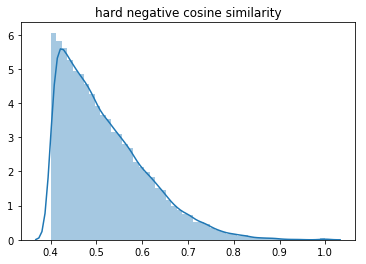

In [621]:
sns.distplot(biosent_hardnegative_scores).set_title('hard negative cosine similarity')

In [ ]:
def get_qa_false_hard(gold, pairs, n, min_threshold, max_threshold=0.9):
    '''Get n false-easy snippets from a true (gold) QA object.'''
    original_n = n
    
    print("GOLD SENTENCE:\n\n" + gold['passage'] + "\n\n")
    print("FALSE HARD SENTENCES:\n")
    
    false_hard = set()
    pairs_to_check = np.arange(len(pairs))
    check = []
    while n > 0 and len(pairs_to_check) > 0:
        check_idx = np.random.randint(len(pairs_to_check))
        idx = pairs_to_check[check_idx]
        check.append(idx)
        pairs_to_check = np.delete(pairs_to_check, check_idx)
        rand_pair = pairs[idx]
            
        gold_sent = gold['passage']
        rand_sent = rand_pair['passage']

        s = abs(similarity(gold_sent, rand_sent))

        if s > min_threshold and s < max_threshold and rand_sent not in false_hard:
            print(f"{original_n - n + 1}. ({s}) [{rand_pair['id'].split('-')[1]} {idx}]\n'{rand_sent}'\n")
            false_hard.add(rand_sent)
            n -= 1
    
    if len(pairs_to_check) == 0:
        print("Searching list was exhausted.")
        
    return list(false_hard)

In [492]:
abst

[{'offsetInBeginSection': 12,
  'offsetInEndSection': 143,
  'text': 'METHODS: Resource use was based on recent primary data (Polyquest Prescriber Analysis, Anemia Patient Record Study in Switzerland).'},
 {'offsetInBeginSection': 236,
  'offsetInEndSection': 334,
  'text': 'Drug costs and costs of materials used were based on official tariffs (Spezialitätenliste, MiGeL).'},
 {'offsetInBeginSection': 335,
  'offsetInEndSection': 433,
  'text': 'Actual IMS sales data of both products were used to verify the BI model (1 CHF ≈ 1 USD, Jan 2013).'},
 {'offsetInBeginSection': 433,
  'offsetInEndSection': 565,
  'text': 'RESULTS: Ferric carboxymaltose was associated with cost savings of 30-44 % per patient per treatment cycle compared to iron sucrose.'},
 {'offsetInBeginSection': 566,
  'offsetInEndSection': 706,
  'text': 'Costs per 200/500/1,000 mg total dosage treatment cycle were CHF 101/210/420 for ferric carboxymaltose and CHF 144/375/721 for iron sucrose.'},
 {'offsetInBeginSection': 7

In [93]:


def get_qa_false_hard(gold, pairs, n, min_threshold, max_threshold=0.9):
    '''Get n false-easy snippets from a true (gold) QA object.'''
    original_n = n
    
    print("GOLD SENTENCE:\n\n" + gold['passage'] + "\n\n")
    print("FALSE HARD SENTENCES:\n")
    
    false_hard = set()
    pairs_to_check = np.arange(len(pairs))
    check = []
    while n > 0 and len(pairs_to_check) > 0:
        check_idx = np.random.randint(len(pairs_to_check))
        idx = pairs_to_check[check_idx]
        check.append(idx)
        pairs_to_check = np.delete(pairs_to_check, check_idx)
        rand_pair = pairs[idx]
            
        gold_sent = gold['passage']
        rand_sent = rand_pair['passage']

        s = abs(similarity(gold_sent, rand_sent))

        if s > min_threshold and s < max_threshold and rand_sent not in false_hard:
            print(f"{original_n - n + 1}. ({s}) [{rand_pair['id'].split('-')[1]} {idx}]\n'{rand_sent}'\n")
            false_hard.add(rand_sent)
            n -= 1
    
    if len(pairs_to_check) == 0:
        print("Searching list was exhausted.")
        
    return list(false_hard)

In [96]:
false_hard = get_qa_false_hard(true_pairs[0], true_pairs, 5, min_threshold=0.1)

GOLD SENTENCE:

Muenke syndrome is characterized by coronal craniosynostosis (bilateral more often than unilateral), hearing loss, developmental delay, and carpal and/or tarsal bone coalition. Tarsal coalition is a distinct feature of Muenke syndrome and has been reported since the initial description of the disorder in the 1990s. 


FALSE HARD SENTENCES:

1. (0.12385855135789026) [23116225 213]
'This review provides an overview of the efficacy and safety of antihypertensive therapy based on olmesartan medoxomil ± hydrochlorothiazide and amlodipine/olmesartan medoxomil in high-risk patient populations enrolled in studies that reported ambulatory BP endpoints'

2. (0.10649297232912369) [23044018 24]
'Muenke syndrome is an autosomal-dominant craniosynostosis syndrome characterized by unilateral or bilateral coronal craniosynostosis, hearing loss, intellectual disability, and relatively subtle limb findings such as carpal bone fusion and tarsal bone fusion'

Searching list was exhausted.


### 2. Negative Easy Pairs

In [13]:
def get_qa_false_easy(gold, n, threshold=0.01):
    global positive_pairs
    '''Get n false-easy snippets from a true (gold) QA object.'''
    original_n = n
    
    gold_sent = gold['passage']
    
    print("GOLD SENTENCE:\n\n" + gold_sent + "\n\n")
    print("FALSE EASY SENTENCES:\n")
    false_easy = set()
    
    while n > 0:
        rand_pair = true_pairs[np.random.randint(len(true_pairs))]
        
        if rand_pair['questionId'] != gold['questionId']:
            gold_sent = gold['passage']
            rand_sent = rand_pair['passage']
            
            s = abs(similarity(gold_sent, rand_sent))
            
            if s < threshold and rand_sent not in false_easy:
                print(f"{original_n - n + 1}. ({s})\n'{rand_sent}'\n")
                false_easy.add(rand_sent)
                n -= 1
                
    return list(false_easy)

In [14]:
false_easy = get_qa_false_easy(true_pairs[0], 5, threshold=0.02)

GOLD SENTENCE:

Muenke syndrome is characterized by coronal craniosynostosis (bilateral more often than unilateral), hearing loss, developmental delay, and carpal and/or tarsal bone coalition. Tarsal coalition is a distinct feature of Muenke syndrome and has been reported since the initial description of the disorder in the 1990s. 


FALSE EASY SENTENCES:

1. (0.018803117087473176)
'Influence of the human cohesion establishment factor Ctf4/AND-1 on DNA replication.'

2. (0.012641665898401433)
'is study determined the effect of nonsteroidal anti-inflammatory drug (NSAID) administration on blood pressure in hypertensive patients taking hydrochlorothiazide (HCTZ). '

3. (0.018683252230306535)
'Using cell viability and fluorescent activated cell sorting analysis tests, we demonstrated that captopril inhibited the viability of LNM35 cells by inducing apoptosis, providing insight about the mechanisms underlying its antitumorigenic activities. In view of these experimental findings, we conclu